In [1]:
# load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn

In [2]:
# read the airlines data
data = pd.read_csv('airline_passengers.csv',usecols=[1])

In [3]:
data.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


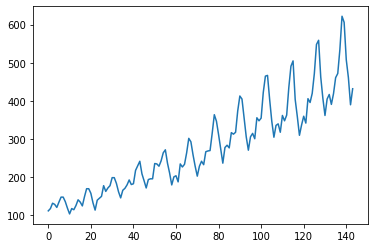

In [4]:
# plot the data
plt.plot(data)

In [5]:
# scale the data
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(0,1))
data = scale.fit_transform(data)

In [6]:
# divide the data into number of steps 
def create_data(data, seq_len):
    N = len(data)
    X = []
    Y = []
    for i in range(N-seq_len-1):
        x = data[i:i+seq_len]
        X.append(x)
        y = data[i+seq_len]
        Y.append(y)
        
    return X,Y

In [7]:
x,y = create_data(data,10)

In [8]:
# convert the x and y values into arrays
x, y = np.asarray(x), np.asarray(y)

In [59]:
x.reshape(-1,10).shape

(133, 10)

In [9]:
# divide the data into train and test
def split_data(x,y, ratio):
    assert len(x)==len(y)
    N = len(x)
    train_x, test_x  = x[:int(N*ratio)], x[int(N*ratio):]
    train_y, test_y  = y[:int(N*ratio)], y[int(N*ratio):]
    return train_x,train_y, test_x, test_y

In [10]:
train_x,train_y, test_x, test_y = split_data(x,y,0.7)

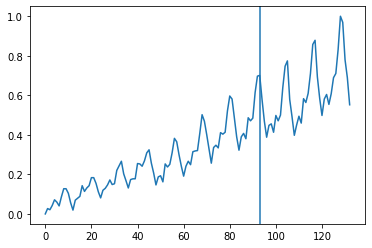

In [11]:
plt.plot(np.vstack((train_y,test_y)))
plt.axvline(int(len(x)*0.7))

In [12]:
# Implement the RNN 
class Simple_RNN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        
        # define the dimensions
        self.in_dim = in_dim
        self.hid_dim = in_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        # define the rnn layer
        self.rnn = nn.RNN(self.in_dim, self.hid_dim, self.layer, nonlinearity='tanh', batch_first=True)
        
        # define fully connected layer for output
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initialize the hidden layer
        h0 = torch.zeros(self.layer, x.size(0),self.hid_dim)
        
        #initialize the rnn
        out, _ = self.rnn(x,h0)
        
        out = self.fc(out[:,-1,:])
        return out

In [13]:
# convert the data from numpy to tensor
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
test_x = torch.from_numpy(test_x.astype(np.float32))
test_y = torch.from_numpy(test_y.astype(np.float32))

In [14]:
x.shape

(133, 10, 1)

In [15]:
# define the network
in_size = x.shape[-1]
out_size = in_size
hid_size = 3
num_layers = 1

model = Simple_RNN(in_size,hid_size,out_size, num_layers)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fun = nn.MSELoss()

In [16]:
def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               epochs=500):
    
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred,y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        if (epoch+1) % 5 ==0:
            print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
    return train_loss, test_loss

In [61]:
train_loss, test_loss = train_model(model,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=500)

Epoch :0.01    Train Loss :0.0019059231271967292    Test Loss :0.007607039995491505
Epoch :0.02    Train Loss :0.0019059231271967292    Test Loss :0.007607039995491505
Epoch :0.03    Train Loss :0.0019059231271967292    Test Loss :0.007607039995491505
Epoch :0.04    Train Loss :0.0019059231271967292    Test Loss :0.007607039995491505
Epoch :0.05    Train Loss :0.0019059231271967292    Test Loss :0.007607039995491505
Epoch :0.06    Train Loss :0.0019059231271967292    Test Loss :0.007607039995491505
Epoch :0.07    Train Loss :0.0019059231271967292    Test Loss :0.007607039995491505
Epoch :0.08    Train Loss :0.0019059231271967292    Test Loss :0.007607039995491505
Epoch :0.09    Train Loss :0.0019059231271967292    Test Loss :0.007607039995491505
Epoch :0.1    Train Loss :0.0019059231271967292    Test Loss :0.007607039995491505
Epoch :0.11    Train Loss :0.0019059231271967292    Test Loss :0.007607039995491505
Epoch :0.12    Train Loss :0.0019059231271967292    Test Loss :0.007607039995

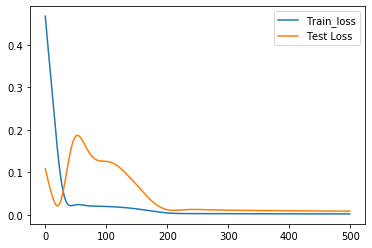

In [18]:
plt.plot(train_loss,label='Train_loss')
plt.plot(test_loss,label='Test Loss')
plt.legend()

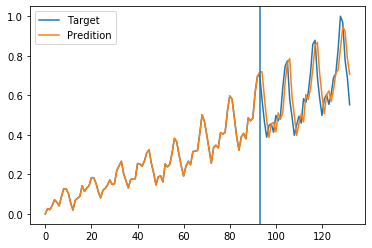

In [19]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),model(test_x).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.7))
plt.legend()

In [20]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(10)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = model(last_x.view(1,10,1))
    prediction_val.append(prediction[0,0].item())
    
    
    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

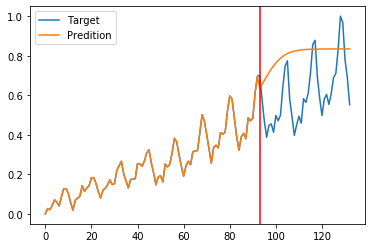

In [21]:
# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.7),color='red')
plt.legend()

In [32]:
# Implement LSTM
class LSTM(nn.Module):
    def __init__(self,in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.lstm = nn.LSTM(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initialize the hidden state
        h0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        c0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        
        # forward propagate
        out, (h_,c_) = self.lstm(x,(h0,c0))
        
        out = self.fc(out[:,-1,:])
        return out

In [43]:
# define the network
in_size = x.shape[-1]
out_size = in_size
hid_size = 5
num_layers = 1

lstm = LSTM(in_size,hid_size,out_size, num_layers)

optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)
loss_fun = nn.MSELoss()

In [44]:
train_loss, test_loss = train_model(lstm,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=500)

Epoch :0.01    Train Loss :0.08809886872768402    Test Loss :0.28696876764297485
Epoch :0.02    Train Loss :0.015262849628925323    Test Loss :0.07489967346191406
Epoch :0.03    Train Loss :0.036908067762851715    Test Loss :0.036181848496198654
Epoch :0.04    Train Loss :0.022008005529642105    Test Loss :0.06553913652896881
Epoch :0.05    Train Loss :0.015110929496586323    Test Loss :0.11560776084661484
Epoch :0.06    Train Loss :0.018217362463474274    Test Loss :0.13421541452407837
Epoch :0.07    Train Loss :0.0161757729947567    Test Loss :0.11360581964254379
Epoch :0.08    Train Loss :0.013309880159795284    Test Loss :0.08209600299596786
Epoch :0.09    Train Loss :0.013338676653802395    Test Loss :0.06477804481983185
Epoch :0.1    Train Loss :0.012481522746384144    Test Loss :0.06501168012619019
Epoch :0.11    Train Loss :0.01127034705132246    Test Loss :0.07164265215396881
Epoch :0.12    Train Loss :0.010755680501461029    Test Loss :0.07118548452854156
Epoch :0.13    Train

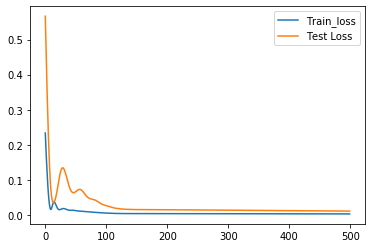

In [45]:
plt.plot(train_loss,label='Train_loss')
plt.plot(test_loss,label='Test Loss')
plt.legend()

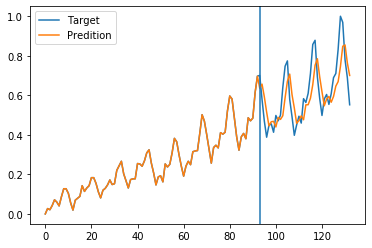

In [46]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),lstm(test_x).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.7))
plt.legend()

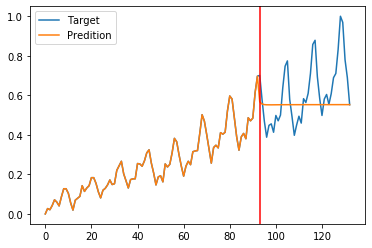

In [47]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(10)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = lstm(last_x.view(1,10,1))
    prediction_val.append(prediction[0,0].item())
    
    
    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))
    
# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.7),color='red')
plt.legend()

In [48]:
# implement GRU
class GRU(nn.Module):
    def __init__(self,in_dim, hid_dim, out_dim, num_layer):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.gru = nn.GRU(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initalize the hidden layers
        h0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        
        out, _ = self.gru(x,h0)
        out = self.fc(out[:,-1,:])
        return out

In [49]:
# define the network
in_size = x.shape[-1]
out_size = in_size
hid_size = 5
num_layers = 1

gru = GRU(in_size,hid_size,out_size, num_layers)

optimizer = torch.optim.Adam(gru.parameters(), lr=0.01)
loss_fun = nn.MSELoss()

In [50]:
train_loss, test_loss = train_model(gru,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=500)

Epoch :0.01    Train Loss :0.10431549698114395    Test Loss :0.4031112790107727
Epoch :0.02    Train Loss :0.02498302236199379    Test Loss :0.1582561433315277
Epoch :0.03    Train Loss :0.03889799490571022    Test Loss :0.07269664108753204
Epoch :0.04    Train Loss :0.0334240198135376    Test Loss :0.09290338307619095
Epoch :0.05    Train Loss :0.02117075026035309    Test Loss :0.15183646976947784
Epoch :0.06    Train Loss :0.023604482412338257    Test Loss :0.18468281626701355
Epoch :0.07    Train Loss :0.022204110398888588    Test Loss :0.16413189470767975
Epoch :0.08    Train Loss :0.01891299895942211    Test Loss :0.12566806375980377
Epoch :0.09    Train Loss :0.018770959228277206    Test Loss :0.10409481823444366
Epoch :0.1    Train Loss :0.017808157950639725    Test Loss :0.10431643575429916
Epoch :0.11    Train Loss :0.016466788947582245    Test Loss :0.11257024109363556
Epoch :0.12    Train Loss :0.01581973023712635    Test Loss :0.11222221702337265
Epoch :0.13    Train Loss :

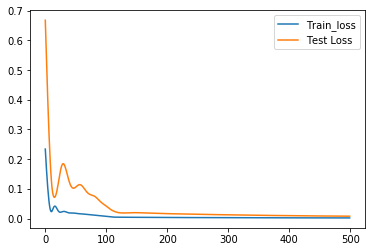

In [51]:
plt.plot(train_loss,label='Train_loss')
plt.plot(test_loss,label='Test Loss')
plt.legend()

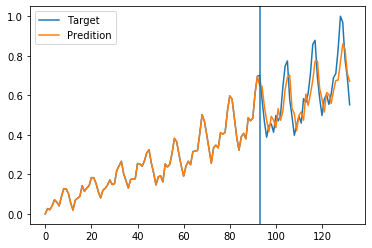

In [52]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),gru(test_x).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.7))
plt.legend()

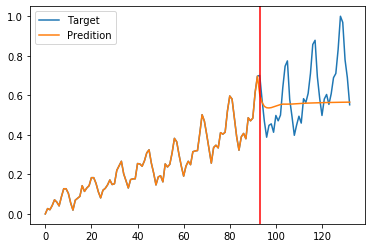

In [53]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(10)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = gru(last_x.view(1,10,1))
    prediction_val.append(prediction[0,0].item())
    
    
    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))
    
# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.7),color='red')
plt.legend()

In [55]:
# Implement Autoregressive model
auto_reg = nn.Linear(10,1)
optimizer = torch.optim.Adam(auto_reg.parameters(), lr=0.01)
loss_fun = nn.MSELoss()

In [62]:
train_loss, test_loss = train_model(auto_reg,
               loss_fun,
               optimizer,
               train_x.reshape(-1,10),
               test_x.reshape(-1,10),
               train_y.reshape(-1,1),
               test_y.reshape(-1,1),
               epochs=500)

Epoch :0.01    Train Loss :0.014670435339212418    Test Loss :0.10051491111516953
Epoch :0.02    Train Loss :0.011478445492684841    Test Loss :0.05624254420399666
Epoch :0.03    Train Loss :0.009668531827628613    Test Loss :0.03490261361002922
Epoch :0.04    Train Loss :0.007584840524941683    Test Loss :0.03556336835026741
Epoch :0.05    Train Loss :0.006658097263425589    Test Loss :0.03195313364267349
Epoch :0.06    Train Loss :0.005737870000302792    Test Loss :0.02435385063290596
Epoch :0.07    Train Loss :0.005292708054184914    Test Loss :0.022134913131594658
Epoch :0.08    Train Loss :0.004909766372293234    Test Loss :0.020633360370993614
Epoch :0.09    Train Loss :0.004579460714012384    Test Loss :0.01888328790664673
Epoch :0.1    Train Loss :0.004303233232349157    Test Loss :0.017602767795324326
Epoch :0.11    Train Loss :0.004018373787403107    Test Loss :0.016383396461606026
Epoch :0.12    Train Loss :0.0037649564910680056    Test Loss :0.015334011986851692
Epoch :0.13

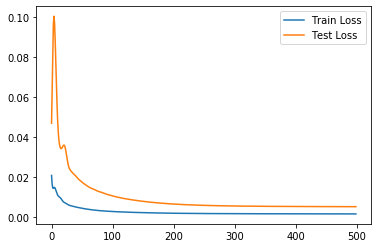

In [63]:
# plot the loss
plt.plot(train_loss,label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend();

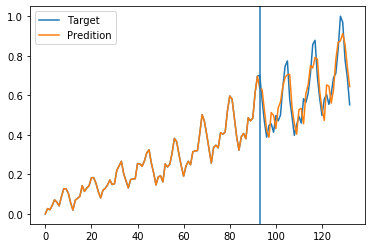

In [65]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),auto_reg(test_x.reshape(-1,10)).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.7))
plt.legend()

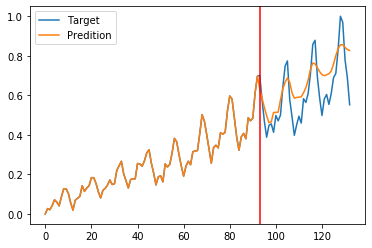

In [66]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(10)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = auto_reg(last_x.view(1,10))
    prediction_val.append(prediction[0,0].item())
    
    
    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))
    
# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.7),color='red')
plt.legend()